# Time series forecasting with ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA time series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model 


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [4]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [14]:
energy = load_data('./data')[['load']]
energy[energy.index >= '2014-11-01 00:00:00']

,load
2014-11-01 00:00:00,"2,514.00"
2014-11-01 01:00:00,"2,434.00"
2014-11-01 02:00:00,"2,390.00"
2014-11-01 03:00:00,"2,382.00"
2014-11-01 04:00:00,"2,419.00"
...,...
2014-12-31 19:00:00,"4,012.00"
2014-12-31 20:00:00,"3,856.00"
2014-12-31 21:00:00,"3,671.00"
2014-12-31 22:00:00,"3,499.00"


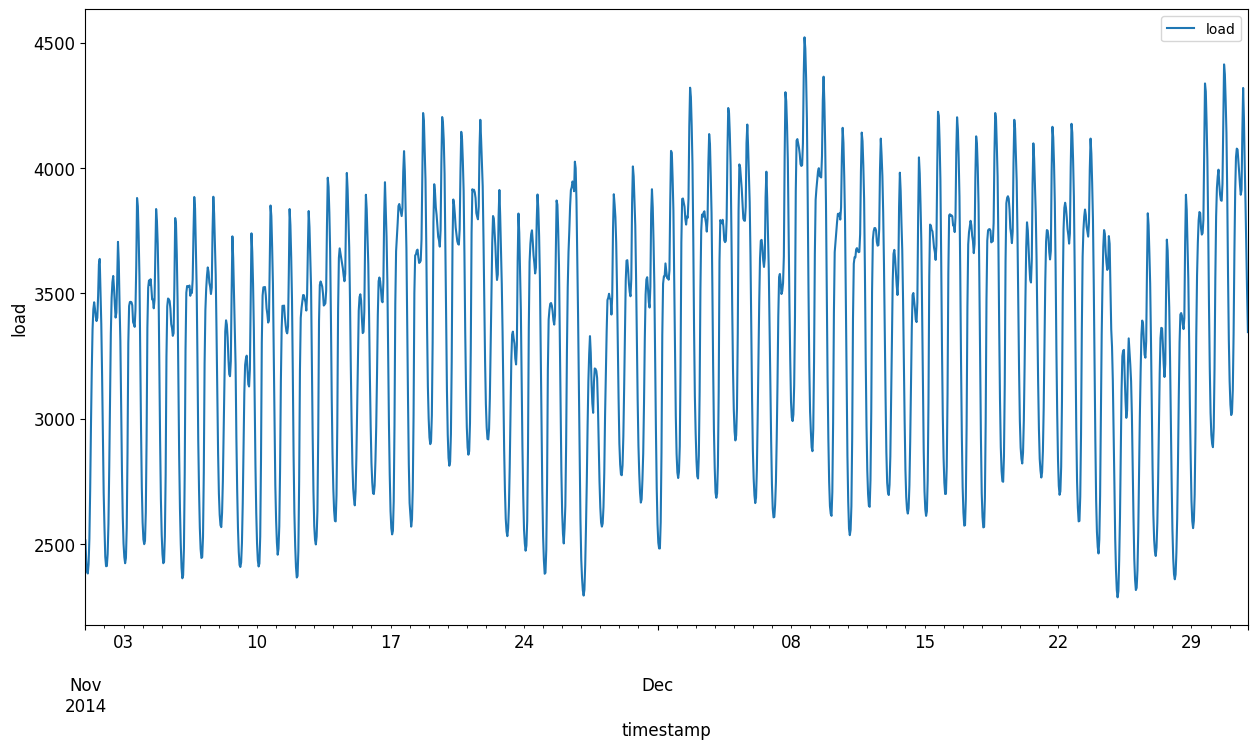

In [15]:
energy[energy.index >= '2014-11-01 00:00:00'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [7]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

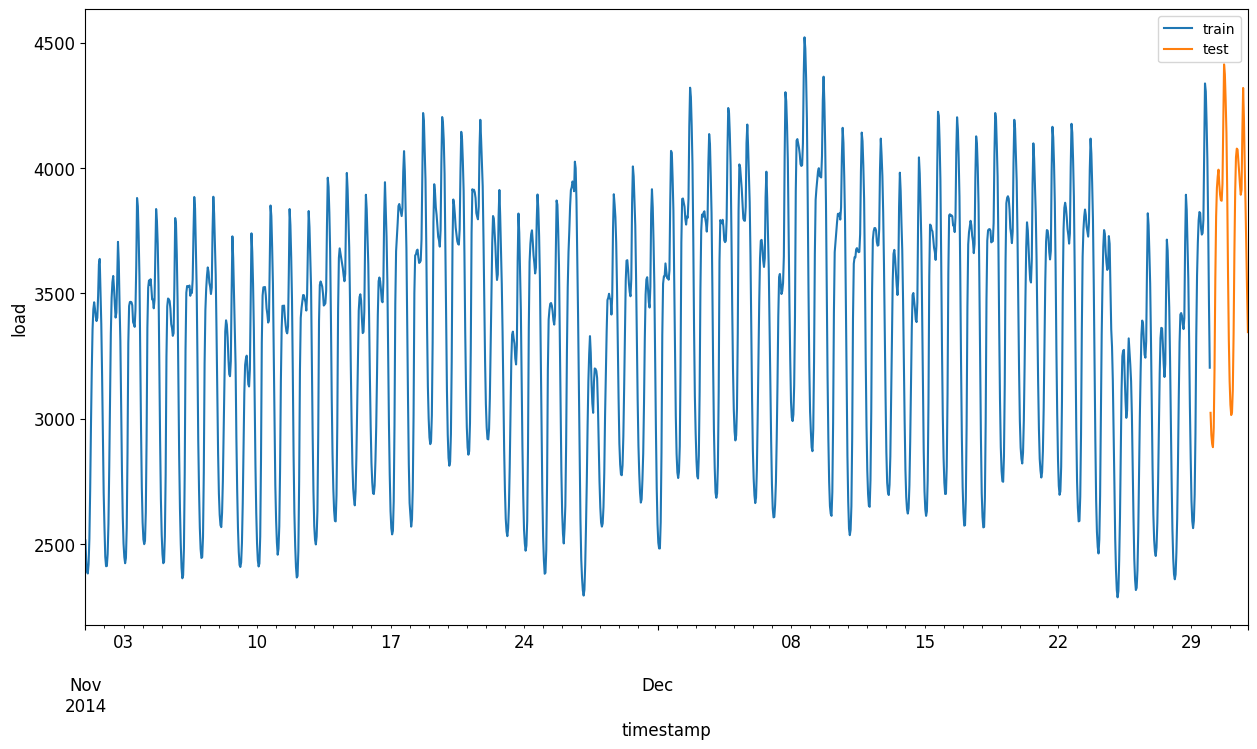

In [10]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [12]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer')

,train,test
2014-11-01 00:00:00,"2,514.00",NaN
2014-11-01 01:00:00,"2,434.00",NaN
2014-11-01 02:00:00,"2,390.00",NaN
2014-11-01 03:00:00,"2,382.00",NaN
2014-11-01 04:00:00,"2,419.00",NaN
...,...,...
2014-12-31 19:00:00,NaN,"4,012.00"
2014-12-31 20:00:00,NaN,"3,856.00"
2014-12-31 21:00:00,NaN,"3,671.00"
2014-12-31 22:00:00,NaN,"3,499.00"


In [16]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [19]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train

,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
...,...
2014-12-29 19:00:00,0.85
2014-12-29 20:00:00,0.78
2014-12-29 21:00:00,0.67
2014-12-29 22:00:00,0.52


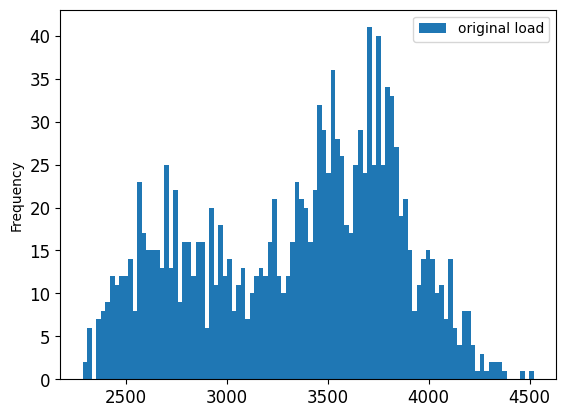

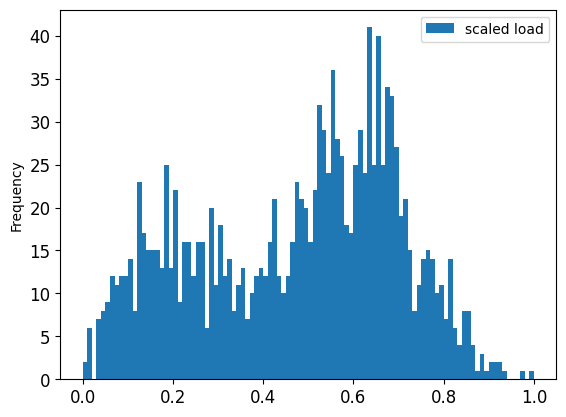

In [20]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [24]:
test['load'] = scaler.fit_transform(test)
test.head()

,load
2014-12-30 00:00:00,0.09
2014-12-30 01:00:00,0.03
2014-12-30 02:00:00,0.01
2014-12-30 03:00:00,0.00
2014-12-30 04:00:00,0.05
